In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
def batch_norm(x,gamma,beta,h_mean,h_var,eps,momentum):
    if not torch.is_grad_enabled():
        x_=(x-h_mean)/torch.sqrt(h_var+eps)
    else:
        assert len(x.shape) in (2,4)
        if len(x.shape)==2:
            mean=x.mean(dim=0)
            var=((x-mean)**2).mean(dim=0)  #和卷积一样，求每个特征（神经元）的平均值
        elif len(x.shape)==4:
            mean=x.mean(dim=(0,2,3),keepdim=True)
            var=((x-mean)**2).mean(dim=(0,2,3),keepdim=True) #把除了通道的其他东西全部加起来，求每个特征的平均值
        x_=(x-mean)/torch.sqrt(var+eps)
        h_mean=momentum*h_mean+(1-momentum)*mean
        h_var=momentum*h_var+(1-momentum)*var
    """合适地改变数据间的差距"""
    y=x_*gamma+beta
    return y,h_mean.data,h_var.data  #加上.data就是输出数字，让其不能被计算梯度更加稳定

In [26]:
class BN(nn.Module):
    def __init__(self,num_features,dims):
        super().__init__()
        if dims==2:
            shape=(1,num_features)
        elif dims==4:
            shape=(1,num_features,1,1)
        """这里放入nn.Parameter可以让gamma和bata随着优化器一起迭代,另外,注意这里第一个P是大写的,是一个类,小写的话代表一个模块"""
        self.gamma=nn.Parameter(torch.ones(size=shape))
        self.beta=nn.Parameter(torch.zeros(size=shape))
        self.h_mean=torch.zeros(shape)
        self.h_var=torch.ones(shape)
    def forward(self,x):
        if self.h_mean.device!=x.device:
            self.h_mean=self.h_mean.to(x.device)
            self.h_var=self.h_var.to(x.device)
        y,self.h_mean,self.h_var=batch_norm(x,self.gamma,self.beta,self.h_mean,self.h_var,eps=1e-5,momentum=0.9)
        return y

In [27]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BN(6, dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BN(16, dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BN(120, dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BN(84, dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.062, train acc 0.978, test acc 0.847
36353.5 examples/sec on cuda:0


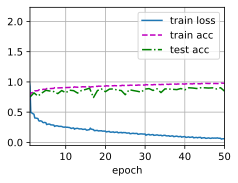

In [ ]:
lr,num_epochs,batch_size=1.0,50,256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())